# Assignment 4 - Feature Selection & Engineering

By Bryan Carr
6 June 2022
for AAI 510
University of San Diego


In this assignment, I will aim to employ at least 3 feature selection & feature engineering techniques to improve the accuracy of the previously developed models. I will also make a new modelling attempt using GBT. Once again we will be using the Home Credit dataset from Kaggle.com:
https://www.kaggle.com/competitions/home-credit-default-risk/data

Early on, let's note that I already did a little imputing and selection during my model building in Assignment 2. Therefore that may make those models slightly difficult to beat. Recall also that the best score was an Accuracy of ~92.4% on the Test data. To see a 20% improvement, we will be targeting an accuracy of nearly 94%, as follows:

In [333]:
target_accuracy = ((100 - 92.4) * 0.2) + 92.4
target_accuracy

93.92

## Importing and Setup

I will begin by importing the required libraries, and the data.

In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer #special feature to enable the experimental Iterative Imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import BayesianRidge
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score, confusion_matrix
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [335]:
application_df = pd.read_csv('data/application_train.csv')

Let's review some basic information for our data:

In [336]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [337]:
application_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [338]:
application_df.columns[0:]

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [339]:
application_df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


We can see a few things briefly:

1) There are a few Null values in some of our columns: AMT_ANNUITY and AMT_GOODS_PRICE. These can probably be computed by a regression with AMT_CREDIT, the size of the loan, as both should be tightly related.
2) OWN_CAR_AGE has a larger number of Null values. Recall that I found this to have a Null when there is no car owned, and filled in appropriate values. The column is expressed as time in years.
3) DAYS_EMPLOYED is mostly negative, as with most of the "DAYS_"-type columns. However, it has a large outlier at DAYS_EMPLOYED == 365243 pulling the mean up. This column is worth a better look at. None of the other 'DAYS_' columns have a positive maximum, as the times are expressed in negative terms (DAYS = 0 would be today; DAYS = -1 would be yesterday; and so on). Remembering from Assignment 1, it seemed as if the positive outlier was applied to Unemployed or Retired individuals - this will be worth looking at again.

As an alternative - perhaps both those columns should be abandoned/dropped. There is no perfect replacement value, especially after scaling, as any value we put in would work backwards and impact the scaling.

Additionally, I'd like to use the many variables relating to the Building. I will try tieing those to other variables relating to the home (price, type, etc.) and using KNN imputation to fill them in with most-similar options.

Another alternative approach would be to use a model algorithm that is tolerant of Null values, such as SKLearn's HistGradientBoostingClassifier, Microsoft's LightGBM, or XGBoost.


Before we continue, we must split the data into Training and Testing, to avoid leaking info from our Test data.

In [341]:
train_df, test_df = train_test_split(application_df, test_size = 0.2, random_state = 1234)

In [342]:
train_df

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
251704,0,Cash loans,M,Y,Y,0,90000.0,207396.0,12816.0,157500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
199948,0,Cash loans,F,N,N,0,135000.0,328500.0,34987.5,328500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
48195,0,Cash loans,F,N,Y,0,225000.0,1123443.0,32845.5,981000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,2.0,2.0
81199,0,Cash loans,M,Y,Y,0,103500.0,203760.0,16227.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
185163,0,Cash loans,F,N,N,0,270000.0,608166.0,57874.5,585000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9449,0,Cash loans,M,Y,N,1,103500.0,526491.0,32337.0,454500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
41239,0,Cash loans,M,N,Y,0,135000.0,314100.0,16573.5,225000.0,...,0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0
294543,0,Cash loans,F,Y,Y,0,135000.0,521280.0,27423.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
220532,0,Cash loans,F,N,Y,1,112500.0,523431.0,34978.5,427500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [343]:
test_df

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
307156,0,Cash loans,F,Y,N,0,121500.0,900000.0,29034.0,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
145177,0,Cash loans,F,N,Y,1,90000.0,545040.0,25537.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
282054,0,Cash loans,F,N,N,0,112500.0,225000.0,15034.5,225000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
105081,0,Cash loans,F,N,N,1,45000.0,544491.0,17563.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
282000,0,Cash loans,M,N,N,1,157500.0,398160.0,10633.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250645,0,Revolving loans,F,N,N,0,135000.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
269262,0,Cash loans,M,Y,N,1,157500.0,450000.0,27193.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
183349,0,Revolving loans,F,N,Y,0,135000.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
173578,1,Cash loans,F,Y,Y,1,112500.0,579942.0,42331.5,495000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,1.0


In [340]:
# We can drop SK_ID_CURR, we won't be needing the column of IDs

application_df.drop(columns=['SK_ID_CURR'], inplace=True, axis=1)

## 1.1: Dealing with Null Values -- Removing Select Rows

Some rows may contain too many null values to be viable. I want to check the data for these and deal with them.

In [344]:
# Count all Nulls in the Dataframe, by Column

train_df.isnull().sum()


TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     33183
AMT_REQ_CREDIT_BUREAU_WEEK    33183
AMT_REQ_CREDIT_BUREAU_MON     33183
AMT_REQ_CREDIT_BUREAU_QRT     33183
AMT_REQ_CREDIT_BUREAU_YEAR    33183
Length: 121, dtype: int64

<AxesSubplot:>

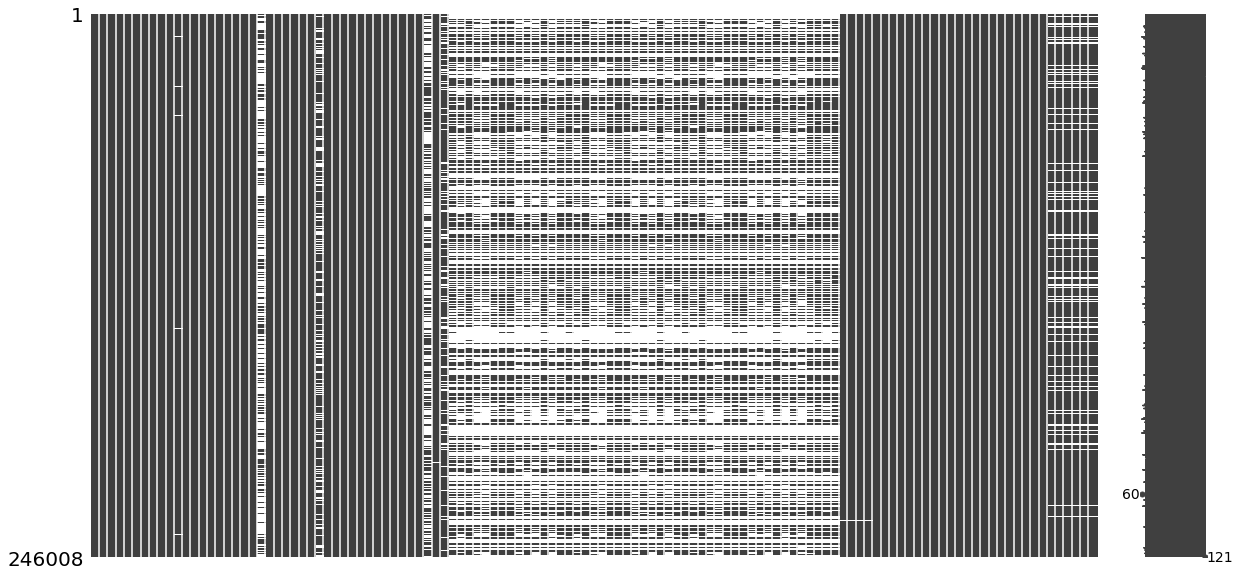

In [345]:
# Plot the Missing Values matrix for the entire Dataframe

mno.matrix(train_df, figsize=(20,10))

<AxesSubplot:>

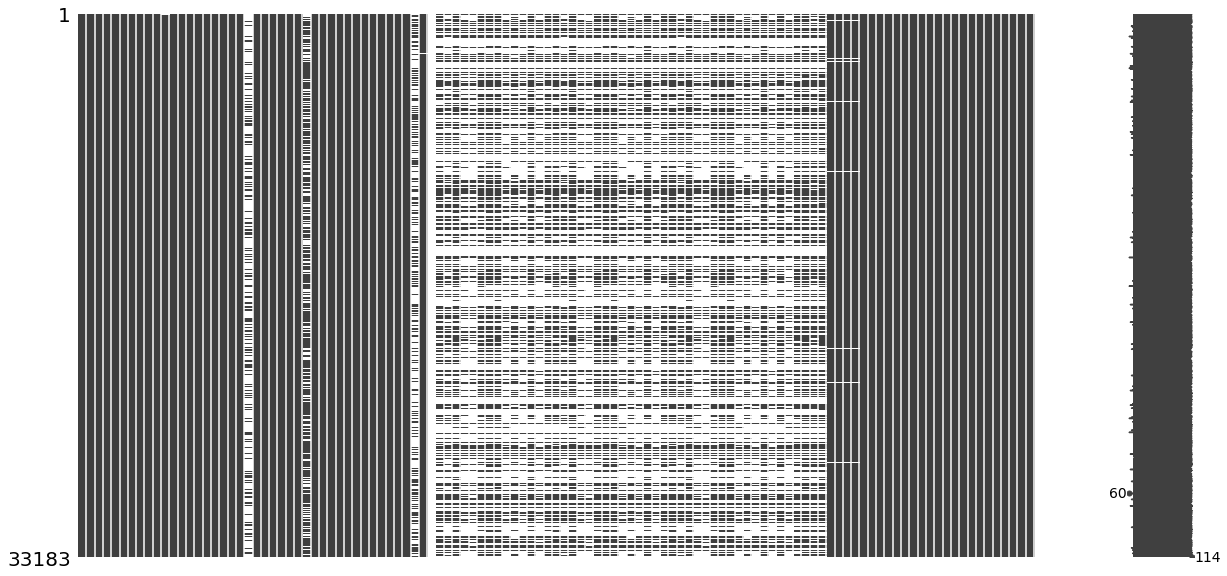

In [346]:
# We can see the last columns appear to be missing values all together. Let's plot a new matrix, for only those rows with those columns missing.

mno.matrix(train_df[train_df['AMT_REQ_CREDIT_BUREAU_MON'].isnull()], figsize=(20,10))

We can see that many of the data points have nulls, but the only consistent one is Ext_Score_3 -- the column right before the group of building-related points in the middle of the dataframe. Let's check this quickly:

In [347]:
# Count the number of Nulls in EXT_SOURCE_3 -- one of the important columns from our PCA and Decision Trees in earlier assignments

train_df[train_df['AMT_REQ_CREDIT_BUREAU_MON'].isnull()].loc[:,'EXT_SOURCE_3'].isnull().sum()


33183

In [348]:
# Let's make sure there are a mix of True and False Target values in this group of data -- it could be that these missing values are representative of something. The documentation describes the columns as 'Number of enquiries to Credit Bureau about the client <some time> before application' -- so probably not, but let's check

train_df[train_df['AMT_REQ_CREDIT_BUREAU_MON'].isnull()].loc[:,'TARGET'].describe()


count    33183.000000
mean         0.103306
std          0.304363
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: TARGET, dtype: float64

We can see there are about 10%, or 3300, of the points in this 'credit enquiries' group that have trouble making their loan payments. It is not homogenous. Based on the Null values in Ext_Source_3 and Ext_Source_1, I feel justified in dropping these and continuing on.

In [349]:
train_df.dropna(axis=0, subset=['AMT_REQ_CREDIT_BUREAU_DAY'], inplace=True)

# Repeat the transformation on the Test Dataframe, to keep our Transformations consistent
test_df.dropna(axis=0, subset=['AMT_REQ_CREDIT_BUREAU_DAY'], inplace=True)

<ipython-input-349-e61ce6dad8d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(axis=0, subset=['AMT_REQ_CREDIT_BUREAU_DAY'], inplace=True)
<ipython-input-349-e61ce6dad8d5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.dropna(axis=0, subset=['AMT_REQ_CREDIT_BUREAU_DAY'], inplace=True)


In [350]:
# Let's review the Null Counts:

train_df.isnull().sum()

TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 121, dtype: int64

## 1.2: Dealing with Null Values -- Owned Car Age

Let's move on to dealing with the Null values in Own_Car_Age, which has 138724 Nulls. Check the relationship with being flagged as Not owning a car:


In [351]:
train_df[train_df['FLAG_OWN_CAR'] == 'N'].isnull().sum().loc['OWN_CAR_AGE']

138721

All but three Nulls are accounted for. We can set them to a representative value -- say several times the standard deviation, in the negative direction. Before we do so, let's check the shape of the Data with a Histogram.

<AxesSubplot:xlabel='OWN_CAR_AGE', ylabel='Count'>

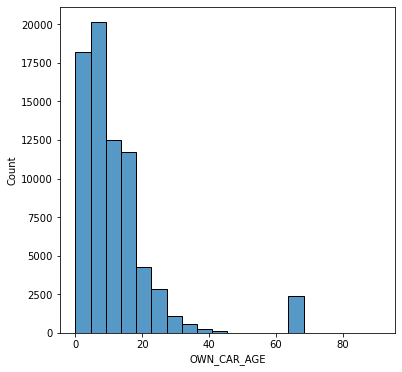

In [352]:
# Check with a Histogram of Own_Car_Age

plt.figure(figsize=(6,6))

own_car_hist = sns.histplot(data=train_df,
                            x='OWN_CAR_AGE',
                            bins=20)
own_car_hist

In [353]:
# Check the Std Dev

train_df.describe()['OWN_CAR_AGE']


count    74101.000000
mean        11.994143
std         11.996524
min          0.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         91.000000
Name: OWN_CAR_AGE, dtype: float64

In [354]:
# Odd that there is an outlier column above 60. Let's have a look at the data

train_df[train_df['OWN_CAR_AGE'] >= 60].loc[:,'OWN_CAR_AGE'].unique()

array([64., 65., 69., 91., 63.])

<AxesSubplot:xlabel='OWN_CAR_AGE', ylabel='Count'>

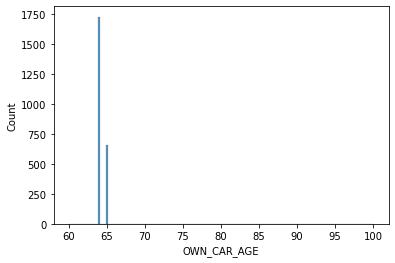

In [355]:
sns.histplot(data=train_df[train_df['OWN_CAR_AGE'] >= 60],
             x='OWN_CAR_AGE',
             binrange=(60,100))

In [356]:
# Check what's happening above this

train_df[train_df['OWN_CAR_AGE'] >= 60].loc[:,'TARGET'].describe()


count    2394.000000
mean        0.084378
std         0.278011
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: TARGET, dtype: float64

These two spikes at 64 and 65 don't make any sense. Why would there suddenly be a group of old cars?

This is an ideal case of going back to the experts and asking how the data was collected, and what these values might represent. Unfortunately that is not possible here, so I will continue on using them. If I dropped them, my model might not handle these values well in the Test set.

As we have car ages going into 40+ years and a Std Dev of approx 11, I will fill in the Nulls with -2* the Std Dev, which I think is sufficiently outlying. This should be easy for the Trees to pick up, without excessively skewing the data.

In [357]:
train_df['OWN_CAR_AGE'].fillna(value=(-2 * train_df.std()['OWN_CAR_AGE']), inplace=True)

# Repeat this Transformation on the Test Data
test_df['OWN_CAR_AGE'].fillna(value=(-2 * train_df.std()['OWN_CAR_AGE']), inplace=True)

C:\Users\bcarr\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [358]:
# Check Null Values again
train_df.isnull().sum()


TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 121, dtype: int64

## 1.3: Dealing with Null Values -- Occupation Type

There are 66561 Nulls for Occupation Type, representing a significant amount. Let's investigate and see if we can do anything about them.

In [359]:
train_df[train_df['OCCUPATION_TYPE'].isnull()]

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
252718,0,Cash loans,F,N,N,0,247500.0,450000.0,50904.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0
126294,0,Cash loans,F,N,N,0,243000.0,1080000.0,31576.5,1080000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
43503,0,Cash loans,F,N,Y,0,90000.0,233208.0,15714.0,184500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
263367,0,Revolving loans,M,Y,Y,0,360000.0,495000.0,24750.0,495000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
92895,1,Cash loans,F,N,N,0,45000.0,675000.0,21775.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238537,0,Cash loans,M,N,Y,0,157500.0,509400.0,40374.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
8060,0,Cash loans,M,Y,Y,1,270000.0,373311.0,19188.0,283500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
40684,0,Cash loans,M,N,N,0,90000.0,255960.0,11929.5,202500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
139294,0,Cash loans,F,N,N,1,99000.0,314100.0,16573.5,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0


In [360]:
# We are reminded there is a large outlier in Days_Employed, which appears to correlate to Pensioners. Let's check that.

train_df[train_df['DAYS_EMPLOYED'] > 0].describe()['DAYS_EMPLOYED']

count     38137.0
mean     365243.0
std           0.0
min      365243.0
25%      365243.0
50%      365243.0
75%      365243.0
max      365243.0
Name: DAYS_EMPLOYED, dtype: float64

In [361]:
# There is only one value. Let's get the Std Dev for the negative values -- representing actual employment

std_days_emp = train_df[train_df['DAYS_EMPLOYED'] <= 0].std()['DAYS_EMPLOYED']
std_days_emp

2375.5460767301115

In [362]:
train_df[train_df['DAYS_EMPLOYED'] <= 0].describe()['DAYS_EMPLOYED']

count    174688.000000
mean      -2450.107827
std        2375.546077
min      -17912.000000
25%       -3270.000000
50%       -1704.000000
75%        -798.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

In [363]:
# With a mean nearly equal to the Std Dev, let's replace the outliers with 5000, or approx 2* Std_Dev.

train_df['DAYS_EMPLOYED'].mask(train_df['DAYS_EMPLOYED'] > 1, 5000.0, inplace=True)

#Repeat the transformation for the Test Set
test_df['DAYS_EMPLOYED'].mask(test_df['DAYS_EMPLOYED'] > 1, 5000.0, inplace=True)

C:\Users\bcarr\anaconda3\lib\site-packages\pandas\core\generic.py:9004: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(
C:\Users\bcarr\anaconda3\lib\site-packages\pandas\core\generic.py:9004: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(


Back to Occupation Type -- let's compare with Income Types

In [364]:
train_df[train_df['OCCUPATION_TYPE'].isnull()]['NAME_INCOME_TYPE'].value_counts()

Pensioner               38137
Working                 17196
Commercial associate     8488
State servant            2731
Student                     5
Unemployed                  3
Businessman                 1
Name: NAME_INCOME_TYPE, dtype: int64

We can see there is a range of different types of income -- it would not be fair to cast one to all of the unknown 'Occupation Types'. Therefore I will introduce a 'Unknown' entry for Occupation Type, and replace the NANs with it. Since I will eventually use One-Hot Encoding for the Categorical Variables, this will result in the addition of a column to the encoded dataset, but will save those entries from possibly being dropped.

In [365]:
train_df['OCCUPATION_TYPE'].mask(train_df['OCCUPATION_TYPE'].isnull(), 'Unknown', inplace=True)

test_df['OCCUPATION_TYPE'].mask(test_df['OCCUPATION_TYPE'].isnull(), 'Unknown', inplace=True)

In [366]:
train_df.isnull().sum()

TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 121, dtype: int64

In [367]:
# Check the data for nulls again to see how we're doing
test_df.isnull().sum()


TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 121, dtype: int64

## 2: Early Feature Selection -- Covariance

Recall that, in Assignment 3, I found that Amt_Goods_Price, Amt_Credit, and Amt_Annuity were the top 3 contributors to the first PCA. If those are closely correlated with Amt_Credit - the variable with no Nulls - then I would be comfortable removing then two with Nulls, to reduce the amount of covariant data.

Text(0.5, 1.0, 'Figure 1.1: Amt_Annuity vs Amt_Credit -- Loan Payment vs Total Loan Amount')

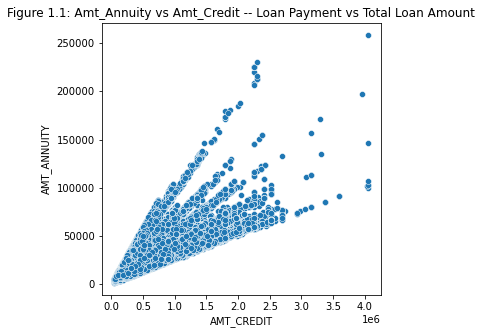

In [368]:
# Plot Amt_Credit vs Amt_Annuity

plt.figure(figsize=(5,5))

annuity_plot = sns.scatterplot(data=train_df,
                               x='AMT_CREDIT',
                               y='AMT_ANNUITY')

annuity_plot.set_title('Figure 1.1: Amt_Annuity vs Amt_Credit -- Loan Payment vs Total Loan Amount')

Text(0.5, 1.0, 'Figure 1.2: Value of Goods vs Total Value of Loan')

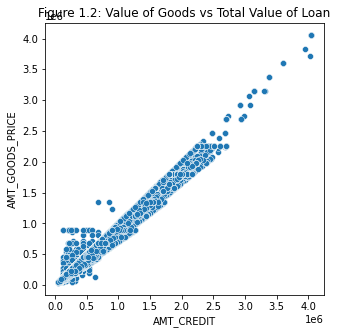

In [369]:
# Plot Goods_Price vs Amt_Credit
plt.figure(figsize=(5,5))
goods_price_plot = sns.scatterplot(data=train_df,
                                   x='AMT_CREDIT',
                                   y='AMT_GOODS_PRICE')

goods_price_plot.set_title('Figure 1.2: Value of Goods vs Total Value of Loan')

Both show clear correlation, but also have some spread. They are not direct variable transforms. Therefore we should not be dropping them, as they do contain info and the variations may have an impact (especially as some Annuity payments are higher, which could be more difficult to pay).

I also plan on dropping NAME_TYPE_SUITE. This column has several Nulls (more than the other two). It also is categorical data representing who came with the applicant to Home Credit’s offices at the time of their application. This info did not feature in the top 20 variables in Assignment 2’s Random Forest, and I have a hard time imagining it is relevant. As the One Hot Encoding would add quite a few columns, I would rather drop it as irrelevant than deal with it.

I wanted to run a KNN Imputer on the Housing columns, to fill them out. However, on second look, the columns are not clear and likely not useful. As classmate Kyle Clark put it, knowing the number of elevators in the building is not relevant to the question of whether someone will fail to make a loan payment. Also, reading the data documentation, the data is 'for the house the applicant lives in' -- so it is not clear if this is their current home, or the one they are applying to purchase with credit. I will, once again, drop these columns.

Let's proceed with dropping these unwanted features: From Apartments_Avg to EmergencyState_Mode

In [370]:
train_df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
199948,0,Cash loans,F,N,N,0,135000.0,328500.0,34987.5,328500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
48195,0,Cash loans,F,N,Y,0,225000.0,1123443.0,32845.5,981000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,2.0,2.0
81199,0,Cash loans,M,Y,Y,0,103500.0,203760.0,16227.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
185163,0,Cash loans,F,N,N,0,270000.0,608166.0,57874.5,585000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
24943,0,Cash loans,F,N,Y,1,450000.0,1113840.0,50463.0,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [371]:
train_df.columns[43]

'APARTMENTS_AVG'

In [372]:
train_df.columns[89]

'EMERGENCYSTATE_MODE'

In [373]:
train_df.drop(axis=1, columns=train_df.columns[43:90], inplace=True)

test_df.drop(axis=1, columns=test_df.columns[43:90], inplace=True)


C:\Users\bcarr\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [374]:
train_df.drop(axis=1, columns='NAME_TYPE_SUITE', inplace=True)

test_df.drop(axis=1, columns='NAME_TYPE_SUITE', inplace=True)


#### Before we proceed any further -- we should split off our Target data as Y, and our Learning data as X

In [375]:
Y_train = train_df.loc[:,'TARGET']
X_train = train_df.drop('TARGET', axis=1)

Y_test = test_df.loc[:,'TARGET']
X_test = test_df.drop('TARGET', axis=1)

In [376]:
X_train.isnull().sum()

NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
CNT_CHILDREN                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 72, dtype: int64

## 3. Encoding, Scaling and Imputing

We still have several columns full of Categorical data, which needs to be split up by Encoding it -- we will use One Hot Encoding to create new columns for each entry.

Then, we will Scale our data with Standard Scaler, to set it around a mean of 0.

Lastly, we will do some imputing to fill in the missing columns. I am intrigued by SK Learn's Iterative Imputer, which can use a Linear Regressor to fill in the datasets with the fewest missing values. In this case we will try the default Bayesian Ridge regressor.

First we need to create appropriate lists of columns. We will build separate Categorical and Binary Encoders (which will produce only 1 True/False column). Then we will scale everything.

In [377]:
X_train.head() #to view the Columns to check on names

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
199948,Cash loans,F,N,N,0,135000.0,328500.0,34987.5,328500.0,Working,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
48195,Cash loans,F,N,Y,0,225000.0,1123443.0,32845.5,981000.0,Commercial associate,...,0,0,0,0,0.0,0.0,0.0,1.0,2.0,2.0
81199,Cash loans,M,Y,Y,0,103500.0,203760.0,16227.0,180000.0,Working,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
185163,Cash loans,F,N,N,0,270000.0,608166.0,57874.5,585000.0,Commercial associate,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
24943,Cash loans,F,N,Y,1,450000.0,1113840.0,50463.0,900000.0,Commercial associate,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [378]:
binary_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

In [379]:
categ_cols = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']

In [380]:
# This Numeric Columns is a leftover from earlier versions, and no longer used

numeric_cols = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [381]:
X_train.isnull().sum()

NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
CNT_CHILDREN                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 72, dtype: int64

In [382]:
# Make Numerical Cols pipeline that Scales, then does Iterative Imputing

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer(verbose=1, random_state=123,
                                 estimator=BayesianRidge(lambda_init=0.1),
                                 missing_values=np.nan,
                                 n_nearest_features=5, # do multi regression on only up to 5 features
                                 initial_strategy='mean' # initially set imputes to the Mean
                                 ))
])

In [383]:
# Make Binary Cols Pipeline
binary_transformer = Pipeline(steps=[
    ('OHE', OneHotEncoder(drop='if_binary', sparse=False))
])

In [384]:
# Make Categorical Cols Pipeline
categ_transformer = Pipeline(steps=[
    ('OneHot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [385]:
# Now make the Column Transformer, to send the labelled columns to the appropriate transformer. The remainder are already encoded as Binary and can pass through.

col_transformer = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categ_transformer, categ_cols),
        ('binary', binary_transformer, binary_cols)
    ],
    remainder='passthrough'
)

In [386]:
# Fit and Transform our X_Train dataframe
X_train_PreProcessed = col_transformer.fit_transform(X_train)


[IterativeImputer] Completing matrix with shape (212825, 29)
[IterativeImputer] Change: 2.458285103702695, scaled tolerance: 0.4281223927652714 
[IterativeImputer] Change: 1.3354878958358847, scaled tolerance: 0.4281223927652714 
[IterativeImputer] Change: 0.9295653802868943, scaled tolerance: 0.4281223927652714 
[IterativeImputer] Change: 1.286863224577218, scaled tolerance: 0.4281223927652714 
[IterativeImputer] Change: 2.1421315443542537, scaled tolerance: 0.4281223927652714 
[IterativeImputer] Change: 2.4074084246292986, scaled tolerance: 0.4281223927652714 
[IterativeImputer] Change: 1.0043445857695832, scaled tolerance: 0.4281223927652714 
[IterativeImputer] Change: 1.268948845658684, scaled tolerance: 0.4281223927652714 
[IterativeImputer] Change: 2.1849731012426643, scaled tolerance: 0.4281223927652714 
[IterativeImputer] Change: 2.547981304171393, scaled tolerance: 0.4281223927652714 


C:\Users\bcarr\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [387]:
# Transform only our X_Test dataframe
X_test_PreProcessed = col_transformer.transform(X_test)

[IterativeImputer] Completing matrix with shape (53167, 29)


In [388]:
X_train_PreProcessed.shape

(212825, 176)

## 4. Check PCA Results

We now have scaled and transformed data, but with 176 columns, which is quite large. With PCA we can likely cut that down significantly. Let's see how successful a PCA might be.


In [389]:
pca = PCA(n_components=60)

pca_data = pca.fit_transform(X_train_PreProcessed)

In [390]:
pca.explained_variance_ratio_

array([0.09192995, 0.08735412, 0.07097507, 0.06420686, 0.04582031,
       0.03758474, 0.03724822, 0.03562646, 0.03408422, 0.03178622,
       0.02829245, 0.02793273, 0.027028  , 0.02646582, 0.02592512,
       0.02456751, 0.02359156, 0.02168952, 0.02052625, 0.01928748,
       0.01863527, 0.01634513, 0.01232274, 0.01027228, 0.00856101,
       0.00835812, 0.00811999, 0.00790288, 0.00661985, 0.00627023,
       0.00581888, 0.0055513 , 0.00489448, 0.00482159, 0.00474997,
       0.00467193, 0.0046126 , 0.00420979, 0.0040412 , 0.00382193,
       0.00361637, 0.0033205 , 0.00324297, 0.00322057, 0.00306766,
       0.00238172, 0.00231942, 0.00220554, 0.00220302, 0.00214107,
       0.00205173, 0.00193383, 0.0018709 , 0.00163998, 0.0015915 ,
       0.00151059, 0.00148806, 0.00146319, 0.00136498, 0.00134614])

In [391]:
sum(pca.explained_variance_ratio_)

0.9765035140180528

[Text(0.5, 0, 'Primary Component (Number)'), Text(0, 0.5, 'Variance Ratio')]

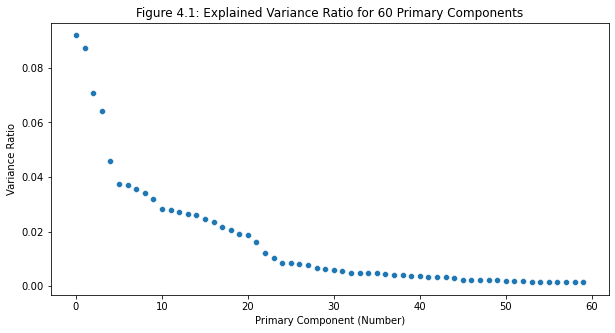

In [392]:
plt.figure(figsize=(10,5))

g1 = sns.scatterplot(
    data=pca.explained_variance_ratio_
)
g1.set_title('Figure 4.1: Explained Variance Ratio for 60 Primary Components')
g1.set(xlabel = 'Primary Component (Number)',
       ylabel='Variance Ratio')

We can see from the sum that over 97.6% of our dataframe's variance can be described with 60 principal components - a big step down in complexity from 176. 60 was a guess (I first tried 50, which got about 95% of the info) and it is a pretty good one, I'll stick with it.

(In the future, we could do some hyperparameter tuning on that N to find an ideal number where variance captured tapers off, by looping over various N and recording the sum of explained variance.)

We'll now transform our data into this new PCA Space

In [393]:
X_train_pca = pca.transform(X_train_PreProcessed)

X_train_pca.shape

(212825, 60)

In [394]:
X_test_pca = pca.transform(X_test_PreProcessed)

X_test_pca.shape

(53167, 60)

## 5. Rebuild Decision Tree models from Assignment 2

I will now rebuild the Decision Tree model from Assignment 2, but with the newly transformed data. We can then see how our new model performs.

In [395]:
# Initialize/Build the Model
decision_tree = tree.DecisionTreeClassifier(max_depth=20, min_samples_split=10, random_state=123)


In [396]:
# Train and Fit the model

decision_tree.fit(X_train_pca, Y_train)

DecisionTreeClassifier(max_depth=20, min_samples_split=10, random_state=123)

In [397]:
decision_tree.score(X_train_pca, Y_train)

0.9559544226477152

In [398]:
decision_tree.score(X_test_pca, Y_test)

0.8854176462843493

This is actually a DECREASE in accuracy from 89.7% in Assignment 2, to 88.6% now. It seems like including and treating more data this time has actually hindered us. Note that the Assignment 2 training dataframe has 246,008 rows, compared to 212,825 here.

Some possible sources for this loss of accuracy:
1) Dropping additional data early on, vs assignment 2's simple approach to include everything and impute with the mean
2) Cutting some data out with our PCA -- the 97.6% of performance is costing us. This will need to be corrected in the future.

Let's try not using the PCA data, to test hypothesis 2.


Before building the forest, we should check the Recall Scores. This was noted in yoru feedback on Assignment 2 as being more important than Accuracy, and it makes sense -- we want to focus on getting all our Positive estimates correct, not necessarily the Negative ones which make up the majority of responses, as the Positives are the problems.

In [399]:
decision_tree_2 = tree.DecisionTreeClassifier(max_depth=20, min_samples_split=10, random_state=123)

In [400]:
decision_tree_2.fit(X_train_PreProcessed, Y_train)

DecisionTreeClassifier(max_depth=20, min_samples_split=10, random_state=123)

In [401]:
decision_tree_2.score(X_train_PreProcessed, Y_train)

0.9513262069775638

In [402]:
decision_tree_2.score(X_test_PreProcessed, Y_test)

0.899072733086313

This is looking better - we are above Assignment 2's accuracy, at least. In the future, we should not be so quick to drop data early on, as that is proving to be a big problem. However, we can clearly see some improvement from not using the PCA, where even with 60 variables we were losing some information. This makes me think we should target an extremely high information inclusion in our PCA if we were to go that route.

Before moving on and building the Random Forest, we should check the Recall Scores. This was noted in your feedback on Assignment 2 as being more important than Accuracy, and it makes sense -- we want to focus on getting all our Positive estimates correct, not necessarily the Negative ones which make up the majority of responses, as the Positives are the problems.

In [403]:
recall_score(Y_test, decision_tree.predict(X_test_pca))

0.11572481572481573

In [404]:
# Shockingly low. Let's check the Training, that must have been better
recall_score(Y_train, decision_tree.predict(X_train_pca))

0.500820020652372

In [405]:
# Let's check for the Non-PCA classified, Decision_Tree_2
recall_score(Y_test, decision_tree_2.predict((X_test_PreProcessed)))

0.10810810810810811

In [406]:
# Even worse! What about for training:
recall_score(Y_train, decision_tree_2.predict(X_train_PreProcessed))

0.4368584097673571

These recall scores are very bad. We would be exposing our company to some bad loans. We should try one last time with Weights for our classes, to weight the Positive class higher than the Negative one

In [407]:
weights = {0:0.1, 1:10.0}

In [408]:
decision_tree_3 = tree.DecisionTreeClassifier(max_depth=20, min_samples_split=10, random_state=123, class_weight=weights)

In [409]:
decision_tree_3.fit(X_train_PreProcessed,Y_train)

DecisionTreeClassifier(class_weight={0: 0.1, 1: 10.0}, max_depth=20,
                       min_samples_split=10, random_state=123)

In [410]:
decision_tree_3.score(X_test_PreProcessed,Y_test)

0.3778095435138338

In [411]:
recall_score(Y_test, decision_tree_3.predict(X_test_PreProcessed))

0.8484029484029484

This approach shows some promise and should be followed in the future. Making a mental note. Further hyperparameter tuning on these Weights should also be performed, to find a balance where enough Negative answers are correct (and thus not unfairly rejected), while catching enough of the Positive values we *should* reject.

## 6. Building and Evaluating the Random Forest model

Time to build the Random Forest model and evaluate it.

In [412]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=30, min_samples_split=10, n_jobs=-1, random_state=1234, verbose=1)

In [413]:
random_forest.fit(X_train_PreProcessed, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished


RandomForestClassifier(max_depth=30, min_samples_split=10, n_jobs=-1,
                       random_state=1234, verbose=1)

In [414]:
# Training Accuracy
random_forest.score(X_train_PreProcessed, Y_train)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.8s finished


0.9354822036884765

In [415]:
# Test Accuracy
rf_test_acc = random_forest.score(X_test_PreProcessed, Y_test)
rf_test_acc

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9234863731261873

In [416]:
# Training Recall
recall_score(Y_train, random_forest.predict(X_train_PreProcessed))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished


0.16594788313187148

In [417]:
# Test Recall
recall_score(Y_test, random_forest.predict((X_test_PreProcessed)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


0.0004914004914004914

At 92.34% Accuracy, we have achieved a slightly lower result compared to Assignment 2's data, which had 92.5% Accuracy. We have also acheived an abysmal Recall score -- these random forests are fitting for the negative case all too often, and failing to predict positive values very well. In essence, we should see a confusion matrix very heavily weighted towards Negative predictions. This is close to the performance of a dummy classifier which only picks Negative, which is horrible for solving our business problem of issuing loans to those who can repay them. We are very close to giving everyone a loan, denying only 0.0005%!

In [418]:
Y_test.shape

(53167,)

In [419]:
# Total count of Positives
Y_test.sum()

4070

In [420]:
# The score for a DUmmy Classifier predicting all Negatives, and getting the Positives all wrong, would be:
dummy_score = 1 - ( Y_test.sum() / Y_test.shape[0] )
dummy_score

0.9234487558071737

In [421]:
rf_test_acc - dummy_score

3.761731901363863e-05

Indeed, we are only 0.0037% better than the dummy classifier would be. Astoundingly bad in terms of recall.

None the less we have learned some important lessons here:
1) Don't drop too many rows too early on. Additional Rows to train the model on appear to be more valuable than fancy regression-based imputation
2) Don't rely on PCA to simplify the data set, unless it contains nearly all of the data
3) Weighting the positive class value will be very important in this sort of problem.

Let's try one last Random Forest with some weights. The previous ones were too aggressive and down played the negative values too much, so I will bring them closer together -- a factor of 50 apart instead of 100 (i.e. y=10 / x=0.1)

In [422]:
weights2 = {0:1.0, 1:50.0}

In [423]:
random_forest2 = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=10, n_jobs=-1, random_state=1234, verbose=1, class_weight=weights2)

In [424]:
random_forest2.fit(X_train_PreProcessed, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.4s finished


RandomForestClassifier(class_weight={0: 1.0, 1: 50.0}, max_depth=20,
                       min_samples_split=10, n_jobs=-1, random_state=1234,
                       verbose=1)

In [425]:
# Training Accuracy
random_forest2.score(X_train_PreProcessed, Y_train)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


0.672557265358863

In [426]:
# Testing Accuracy
random_forest2.score(X_test_PreProcessed, Y_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


0.6269678560009028

In [427]:
# Training Recall
recall_score(Y_train, random_forest2.predict(X_train_PreProcessed))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished


0.9999392577294539

In [428]:
#Testing Recall
recall_score(Y_test, random_forest2.predict(X_test_PreProcessed))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


0.7174447174447175

Though the accuracies are much worse across the board, our Recall score is significantly improved. Note that this was also with a lower depth of 20, to reduce potential overfitting (and speed things up as it's getting late). This shows us that a class weight balance of 50x is a good place to start looking when we do hyperparameter tuning.

### 7. Building a Gradient Boosted Tree Classifier with XGBoost

Lastly I will build a gradient boosting classifier with XGBoost. Helpfully, XGB allows us to scale the class weights, which we have seen to be useful.

In [429]:
xgb_class = XGBClassifier(
    n_estimators = 100,
    max_depth = 20,
    verbosity = 1,
    n_jobs = -1,
    random_state = 123,
    scale_pos_weight = 50
)

In [430]:
xgb_class.fit(X_train_PreProcessed, Y_train)

C:\Users\bcarr\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=50, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [431]:
xgb_class.score(X_train_PreProcessed, Y_train)

# for n=10, acc = 85%
# for n=50, acc = 0.9997
# for n=100, acc = 1.0

1.0

In [432]:
recall_score(Y_train, xgb_class.predict(X_train_PreProcessed))

# for n=10, recall = 1.0
# for n=50, recall = 1.0
# for n=100, recall = 1.0

1.0

In [433]:
recall_score(Y_test, xgb_class.predict(X_test_PreProcessed))

# for n=10, recall_test = 48.18%
# for n=50, recall_test = 14.20% -- adding more estimators overfit on the training data
# for n=100, recall = 11.105% -- continuing the trend down from overfitting

0.11105651105651106

In [434]:
xgb_class.score(X_test_PreProcessed, Y_test)

# for n=10, Acc_Test = 75.6%
# for n=50, Acc_Test = 90.31%
# for n=100, Acc_Test = 91.36%

0.9136306355446048

In [435]:
xgb_class.feature_importances_

array([0.00358402, 0.00333702, 0.0036734 , 0.0033532 , 0.00387895,
       0.00306173, 0.00374201, 0.0033804 , 0.00301386, 0.0032278 ,
       0.00351421, 0.00347657, 0.0028499 , 0.00424792, 0.00332427,
       0.00414427, 0.00489245, 0.00577074, 0.00321175, 0.00418545,
       0.00271621, 0.00687623, 0.00325286, 0.00742705, 0.0066408 ,
       0.00769509, 0.0055167 , 0.00469714, 0.00307245, 0.        ,
       0.00302236, 0.        , 0.        , 0.00550184, 0.        ,
       0.        , 0.00280684, 0.        , 0.00530288, 0.00643795,
       0.00688802, 0.00400095, 0.00364902, 0.00253021, 0.00503948,
       0.00343543, 0.        , 0.0061226 , 0.0104195 , 0.00338777,
       0.00672416, 0.00872749, 0.007335  , 0.00391317, 0.00843515,
       0.00505859, 0.00636719, 0.00527689, 0.00379149, 0.00682867,
       0.00796403, 0.01364094, 0.00276807, 0.00566638, 0.00656862,
       0.00748547, 0.01221106, 0.00905276, 0.00388875, 0.00863495,
       0.00743049, 0.00280723, 0.01103219, 0.00351422, 0.00313

Given we are overfitting with higher N_Estimators (i.e. rounds of boosting), I will try one last round with a shorter tree, and smaller N

In [436]:
xgb_class_short = XGBClassifier(
    n_estimators = 75,
    max_depth = 11,
    verbosity = 2,
    n_jobs = -1,
    random_state = 123,
    scale_pos_weight = 50
)

In [437]:
xgb_class_short.fit(X_train_PreProcessed, Y_train)

[22:45:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 1280 extra nodes, 0 pruned nodes, max_depth=11
[22:45:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:45:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 1092 extra nodes, 0 pruned nodes, max_depth=11
[22:45:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 1236 extra nodes, 0 pruned nodes, max_depth=11
[22:45:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 1106 extra nodes, 0 pruned nodes, max_dep

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=11, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=75, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=50, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=2)

In [438]:
# Training Accuracy:
xgb_class_short.score(X_train_PreProcessed, Y_train)

0.7636743803594502

In [439]:
# Training Recall:
recall_score(Y_train, xgb_class_short.predict(X_train_PreProcessed))

0.9999392577294539

In [440]:
# Testing Recall:
recall_score(Y_test, xgb_class_short.predict(X_test_PreProcessed))

0.6061425061425061

In [441]:
# Testing Accuracy:
xgb_class_short.score(X_test_PreProcessed, Y_test)

0.6833374085428932

In [442]:
# Let's have a look at the Confusion Matrix for this result, and for the questionable Random Forest. For this Short XGB:

confusion_matrix(Y_test, xgb_class_short.predict(X_test_PreProcessed))

array([[33864, 15233],
       [ 1603,  2467]], dtype=int64)

In [443]:
# COnfusion Matrix for the bad 'dummy classifier' initial random forest

confusion_matrix(Y_test, random_forest.predict(X_test_PreProcessed))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


array([[49097,     0],
       [ 4068,     2]], dtype=int64)

In [444]:
# Confusion matrix for the improved Random Forest #2, with Weights = 50x

confusion_matrix(Y_test, random_forest2.predict((X_test_PreProcessed)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


array([[30414, 18683],
       [ 1150,  2920]], dtype=int64)

This shorter tree model has greatly improved the recall score, by not overfitting as severely. Accuracy and Recall are both fairly close to each other, with 68.3% and 60.6% results, respectively. These are significantly better than the Recall results using decision trees similar to in assignment 2, which emphasizes the importance of weighting our positive results more highly in this unbalanced data set. However, with results in the 60% range, we are probably still some ways off from deploying the model into use in the business.

Unfortuantely, none of my models are competitive with the top testing accuracy in Assignment 2 of 92.4%. But we also found that that score is a bit of an anomaly, being very close to the Dummy Classifier 'Predict all Zeros' result. I'm happy with this baseline to improve on with hyperparamater tuning.

We also saw in this assignment the importance of conserving our data, over fancier techniques. Lesson learned, don't prune too much data!